In [90]:
import Pkg
Pkg.activate(".")

  Activating project at `~/BME574`


In [91]:
Pkg.add(["CairoMakie","LinearAlgebra","Distributions","Convex","SCS","StatsPlots"])

   Resolving package versions...
  No Changes to `~/BME574/Project.toml`
  No Changes to `~/BME574/Manifest.toml`


In [92]:
using CairoMakie, Distributions, LinearAlgebra, Convex, SCS, Random, StatsPlots

In [93]:
n = 100  
m = 20 #specific integer  
x = LinRange(-2, 2, n)
y = x.^2

100-element Vector{Float64}:
 4.0
 3.8400163248648105
 3.683297622691562
 3.5298438934802574
 3.3796551372308943
 3.232731353943475
 3.089072543617999
 2.9486787062544635
 2.8115498418528726
 2.6776859504132227
 2.5470870319355168
 2.4197530864197523
 2.295684113865932
 ⋮
 2.4197530864197523
 2.5470870319355168
 2.6776859504132227
 2.8115498418528726
 2.9486787062544635
 3.089072543617999
 3.232731353943475
 3.3796551372308943
 3.5298438934802574
 3.683297622691562
 3.8400163248648105
 4.0

In [94]:
y1 = y .+ rand(Normal(0,0.1),length(y)) #noisy version of y

100-element Vector{Float64}:
 4.252671544835938
 3.8803269079265434
 3.575564840775222
 3.4150899112577005
 3.427451516299746
 3.1869016458128647
 3.035679736416592
 3.015899732866416
 2.745433957472713
 2.795060808624757
 2.5978009663905732
 2.3043791747064035
 2.1948091993682497
 ⋮
 2.3114704716611127
 2.685791505964736
 2.675911793580308
 2.7241508334051163
 2.941672820507172
 3.0072811309402407
 2.990216929728767
 3.2058309740663242
 3.552062392188607
 3.811083065934078
 3.8070051282536714
 3.7812331971478192

In [95]:
#horizonal concatenation: each column coresponds to a different power of x
A = hcat([x .^ p for p in 0:m]...) 

100×21 Matrix{Float64}:
 1.0  -2.0      4.0      -8.0      …  -524288.0            1.04858e6
 1.0  -1.9596   3.84002  -7.52488          -3.55766e5      6.97157e5
 1.0  -1.91919  3.6833   -7.06896          -2.39469e5      4.59587e5
 1.0  -1.87879  3.52984  -6.63183     -159837.0            3.003e5
 1.0  -1.83838  3.37966  -6.2131           -1.05752e5      1.94412e5
 1.0  -1.79798  3.23273  -5.81239  …   -69328.4            1.24651e5
 1.0  -1.75758  3.08907  -5.42928      -45016.0        79119.1
 1.0  -1.71717  2.94868  -5.06339      -28937.5        49690.6
 1.0  -1.67677  2.81155  -4.71432      -18407.1        30864.4
 1.0  -1.63636  2.67769  -4.38167      -11580.2        18949.4
 1.0  -1.59596  2.54709  -4.06505  …    -7201.38       11493.1
 1.0  -1.55556  2.41975  -3.76406       -4424.1         6881.93
 1.0  -1.51515  2.29568  -3.47831       -2683.28        4065.57
 ⋮                                 ⋱                       ⋮
 1.0   1.55556  2.41975   3.76406        4424.1         6881

In [96]:
# function to fit least square fit using the pseudo-inverse of the design matrix
function fitlq(A, y1)
    return pinv(A) * y1
end

fitlq (generic function with 1 method)

In [97]:
# function to fit Lasso regression
function lasso(A, y1, λ1, λ2)
    x = Variable(size(A, 2))
    problem = minimize(norm(A * x - y1, 2) + λ1 * norm(x, 1)+ λ2*norm(x,2))
    solve!(problem, SCS.Optimizer; silent = true)
    return vec(evaluate(x))
end

lasso (generic function with 1 method)

In [98]:
#generate coefficients for least squares and Lasso with noise
realizations = 100
coeffs_ls = zeros(m+1, realizations)
coeffs_lasso = zeros(m+1, realizations)

for i in 1:realizations
    y_noise = x.^2 .+ 0.1 * randn(n)  # Noisy data
    
    #perform regressions with different degree of polynomial fit functions.
    coeffs_ls[:, i] = fitlq(A, y_noise)
    coeffs_lasso[:, i] = lasso(A, y_noise, 0.1, 0.1)  # LASSO with λ1 = 0.1 & λ2 = 0.1
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/6c4lt/src/scenes.jl:229


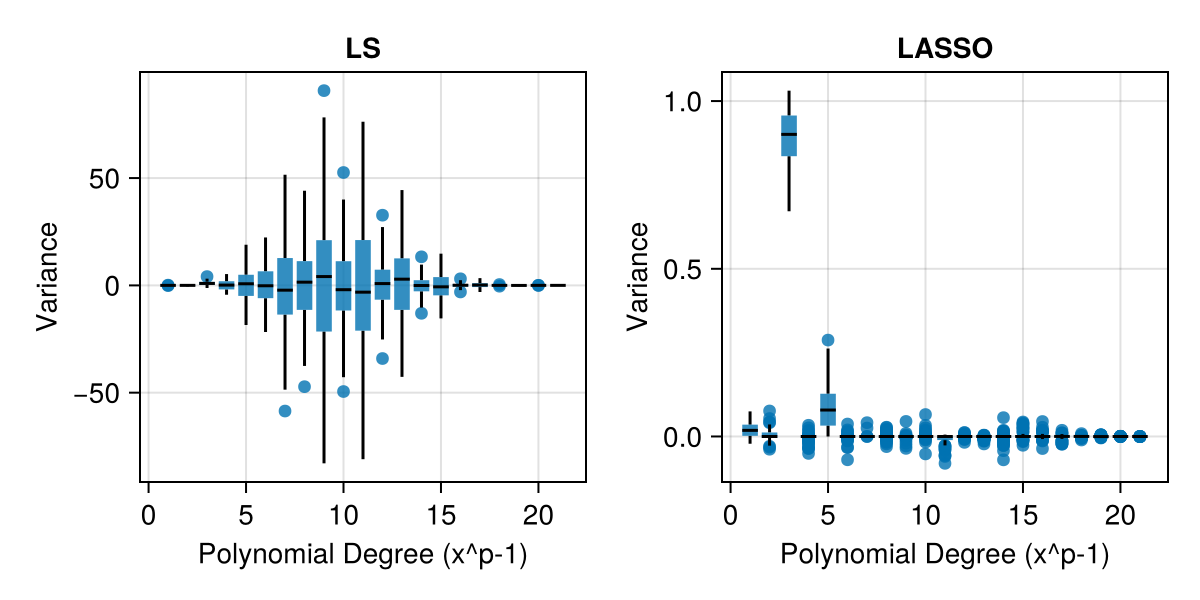

In [100]:
#The two plots display the boxplot of the distributions of fitting parameters of the combined trials
fig = Figure(resolution = (600, 300)) #resolution: width and height 

ls_plot = Axis(fig[1, 1], title = "LS", xlabel = "Polynomial Degree (x^p-1)", ylabel = "Variance")
boxplot!(ls_plot, repeat(1:(m+1), realizations), vec(coeffs_ls))

lasso_plot = Axis(fig[1, 2], title = "LASSO", xlabel = "Polynomial Degree (x^p-1)", ylabel = "Variance")
boxplot!(lasso_plot, repeat(1:(m+1), realizations), vec(coeffs_lasso))

fig

In [101]:
#Noisy data is generated based on the quadratic relationship
#Normalized errors are computed to assess each model
errors_ls = zeros(realizations)
errors_lasso = zeros(realizations)

for i in 1:realizations
    y_noise = x.^2 .+ 0.1 * randn(n)  # Noisy data
    
    # Predicted values from the models
    y_pred_ls = A * coeffs_ls[:, i]
    y_pred_lasso = A * coeffs_lasso[:, i]
    
    # Calculate errors
    errors_ls[i] = norm(y_noise - y_pred_ls) / norm(y_noise)
    errors_lasso[i] = norm(y_noise - y_pred_lasso) / norm(y_noise)
end


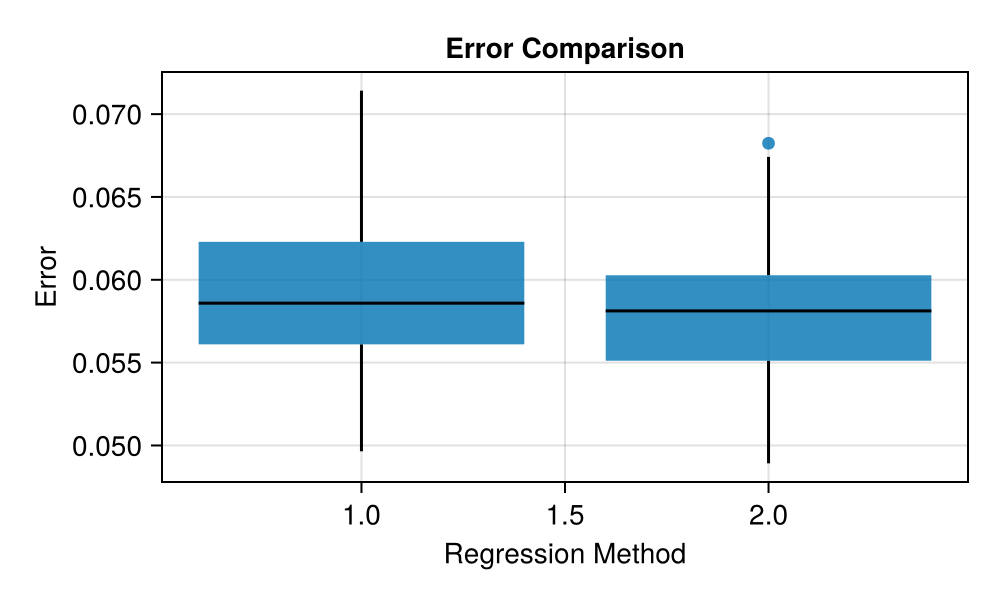

In [102]:
#The two plots display the boxplot of the distributions of fitting parameters of the combined trials
#comparison of error for 2 methods
fig_error = Figure(size = (500, 300))
error_plot = Axis(fig_error[1, 1], title = "Error Comparison", xlabel = "Regression Method", ylabel = "Error")

boxplot!(error_plot, repeat([1, 2], realizations), vcat(errors_ls, errors_lasso))

fig_error

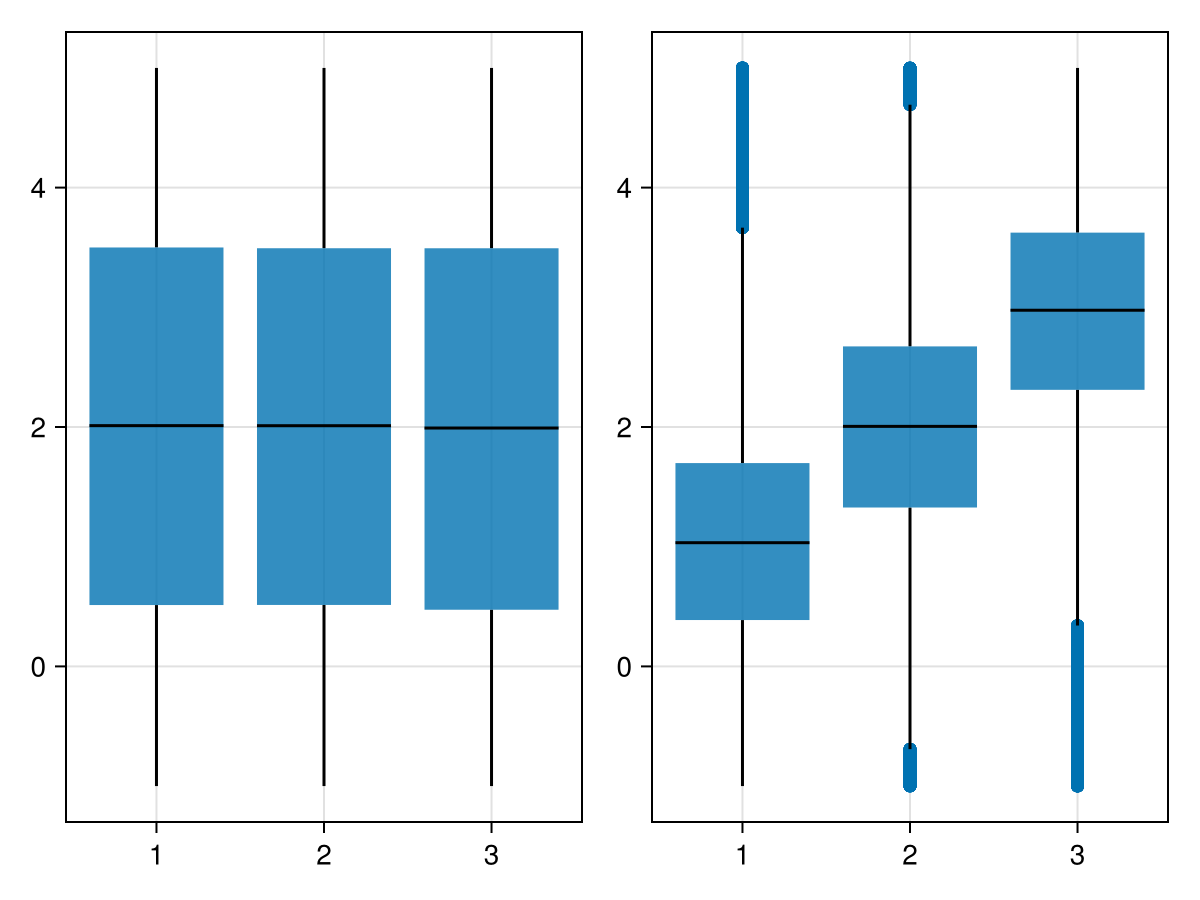

In [106]:
#The error increases slightly by using a higher degree polynomial to fit the data
N = 100_000
x = rand(1:3, N)
y = rand(Uniform(-1, 5), N)

w = pdf.(Normal(), x .- y) #element-wise difference

fig = Figure()

boxplot(fig[1,1], x, y) #displays raw data
boxplot(fig[1,2], x, y, weights = w) #incorporates weights based on the differences between x and y

fig